# Modelagem

---

# 1. Pré-processamento

## 1.1 Carregamentos & importações

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train_raw = pd.read_csv('/kaggle/input/task-02-car-price-prediction/train_car_details.csv')
df_test_raw = pd.read_csv('/kaggle/input/task-02-car-price-prediction/test_car_details.csv')

## 1.2 Formatação nomes das colunas

In [3]:
def fix_col_names(_df: pd.DataFrame, silent: bool = True) -> pd.DataFrame:
    ''' Strips and lowercases DataFrame columns '''
    df = _df.copy()
    og_cols = df.columns.to_list()

    df.columns = df.columns \
        .str.lower() \
        .str.strip()
    
    max_col_name_size = len(max(og_cols, key=lambda x: len(x))) + 5
    if not silent:
        for og, new in zip(og_cols, df.columns.to_list()):
            print(f'{og: <{max_col_name_size}} -> {new}')

    return df

## 1.3 Conversão das colunas object numéricas em float64

In [4]:
def extract_obj_num_col(series: pd.Series, re_pattern: str) -> pd.Series:
    ''' Extracts regex pattern from series and converts to float64 '''
    return series.str.extract(re_pattern, expand=False).astype(np.float64)

def extract_obj_num_col_value_conversion(series: pd.Series, re_pattern: str, convert_values_string: str = '', conversion_rate: float = 1) -> pd.Series:
    ''' Runs extract_obj_num_col and scales values by given amount '''
    conv_rate = series.str.lower() \
        .str.contains(convert_values_string, na=False) \
        .map({False: 1, True: conversion_rate})


    extracted = extract_obj_num_col(series, re_pattern)
    post_conv = conv_rate * extracted

    return post_conv

## 1.4 Marcas e modelos

In [5]:
def extract_brand_model(df: pd.DataFrame, col_name: str = 'name'):
    brand = df[col_name].str.split().str[0]
    model = df[col_name].str.split().str[1]
    extra = df[col_name].str.split().str[2:].str.join(' ')
    
    return brand, model, extra

## 1.5 Juntando todos os passos

In [6]:
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

In [7]:
def preprocess(
    train_set: pd.DataFrame, 
    submission_set: pd.DataFrame,
    target: str,
    split_data: bool = True,
    test_size: float = 0.3,
) -> Tuple[pd.DataFrame, ...]:
    
    # col names
    df_train = fix_col_names(train_set)
    df_test = fix_col_names(submission_set)
    
    # obj col to num
    ## train
    pattern = '(\d+.\d+)'
    df_train['mileage'] = extract_obj_num_col(df_train['mileage'], pattern)
    df_train['engine'] = extract_obj_num_col(df_train['engine'], pattern)
    df_train['max_power'] = extract_obj_num_col(df_train['max_power'], pattern)

    pattern_torque = '(\d+[.\d]?)'
    df_train['torque'] = extract_obj_num_col_value_conversion(
        df_train['torque'], pattern_torque, convert_values_string='kgm', conversion_rate=9.80665
    )
    ## test
    pattern = '(\d+.\d+)'
    df_test['mileage'] = extract_obj_num_col(df_test['mileage'], pattern)
    df_test['engine'] = extract_obj_num_col(df_test['engine'], pattern)
    df_test['max_power'] = extract_obj_num_col(df_test['max_power'], pattern)

    pattern_torque = '(\d+[.\d]?)'
    df_test['torque'] = extract_obj_num_col_value_conversion(
        df_test['torque'], pattern_torque, convert_values_string='kgm', conversion_rate=9.80665
    )
    
    # brands and models
    ## train
    df_train['brand'], df_train['model'], df_train['extra'] = extract_brand_model(df_train)
    
    ## test
    df_test['brand'], df_test['model'], df_test['extra'] = extract_brand_model(df_test)

    # x & y
    x_final = df_train.copy().drop(target, axis=1)
    y_final = df_train[target]

    if split_data:
        # splits
        x_train, x_test, y_train, y_test = train_test_split(
            x_final, y_final, test_size=test_size, random_state=22
        )

        return x_train, x_test, y_train, y_test, x_final, y_final, df_test

    return x_final, y_final, df_test

In [8]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

print(f'''
    x_train: {x_train.shape}, y_train: {y_train.shape}
    x_test:  {x_test.shape}, y_test:  {y_test.shape}
    
    x_final: {x_final.shape}, y_final: {y_final.shape}
    x_submission: {x_submission.shape}
    
''')


    x_train: (3982, 16), y_train: (3982,)
    x_test:  (1707, 16), y_test:  (1707,)
    
    x_final: (5689, 16), y_final: (5689,)
    x_submission: (2375, 16)
    



---

# 2. Modelos

In [9]:
from sklearn.metrics import r2_score, max_error, explained_variance_score, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime

In [10]:
all_scores = {}

def show_scores(scores: dict = all_scores):
#     display(pd.DataFrame(all_scores))
    display(pd.DataFrame(all_scores.values(), index=all_scores.keys()))

def calculate_scores(
    model_name: str, 
    y_test: pd.Series, pred: np.ndarray, 
    score_list: list = all_scores,
    display_scores: bool = True
    ):   
    model_scores = {
        'r2_score': round(r2_score(y_test, pred), 4),
        'max_error': round(max_error(y_test, pred), 2),
        'explained_variance_score': round(explained_variance_score(y_test, pred), 4),
        'mean_absolute_error': round(mean_absolute_error(y_test, pred), 2),
        'mean_absolute_percentage_error': round(mean_absolute_percentage_error(y_test, pred) * 100, 4)
    }
    score_list[model_name] = model_scores
  
    if show_scores:
        show_scores(score_list)
    return model_scores

def export_pred(model_name: str, raw_submission_set: pd.DataFrame, predictions):     
    submission = pd.DataFrame({
        'Id': raw_submission_set['id'],
        'selling_price': predictions
    })
    
    timestamp = datetime.strftime(datetime.now(), '%d-%m-%y_%H%M')
    submission.to_csv(f'/kaggle/working/{model_name}_{timestamp}.csv', index=False)

# 2.1 SVM

## 2.1.1 Basicão

In [11]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, RobustScaler

In [12]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


svr_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    SVR()
)

In [13]:
svr_basic.fit(x_train, y_train)

_preds = svr_basic.predict(x_test)
_ = calculate_scores('svr_basic', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819


É, não deu pro basicão.

# 2.2 LinearRegression

## 2.2.1 Primo do basicão

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


linreg_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    LinearRegression()
)

In [16]:
linreg_basic.fit(x_train, y_train)

_preds = linreg_basic.predict(x_test)
_ = calculate_scores('linreg_basic', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738


# 2.3 AdaBoostRegressor

## 2.3.1 Parametros padrão

In [17]:
from sklearn.ensemble import AdaBoostRegressor

In [18]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


adareg_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    AdaBoostRegressor()
)

In [19]:
adareg_basic.fit(x_train, y_train)

_preds = adareg_basic.predict(x_test)
_ = calculate_scores('adareg_basic', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738


Ainda melhor. Pera, ```mean_absolute_percentage_error > 100```?

## 2.3.2 Outros parametros
Escolhidos manualmente

In [20]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


adareg_manual_params = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    AdaBoostRegressor(
        n_estimators=100, learning_rate=1
    )
)

In [21]:
adareg_manual_params.fit(x_train, y_train)

_preds = adareg_manual_params.predict(x_test)
_ = calculate_scores('adareg_manual_params', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349


# 2.4 GradientBoostingRegressor

## 2.4.1 Parametros padrão

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

In [23]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


gbreg_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    GradientBoostingRegressor()
)

In [24]:
gbreg_basic.fit(x_train, y_train)

_preds = gbreg_basic.predict(x_test)
_ = calculate_scores('gbreg_basic', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531


## 2.4.2 Outros parametros
Escolhidos manualmente

In [25]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


gbreg_manual_params = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    GradientBoostingRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=10, loss='huber'
    )
)

In [26]:
gbreg_manual_params.fit(x_train, y_train)

_preds = gbreg_manual_params.predict(x_test)
_ = calculate_scores('gbreg_manual_params', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910


### 2.4.2.1 Submissão

In [27]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


final_gbreg_manual_params = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    GradientBoostingRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=10, loss='huber'
    )
)

final_gbreg_manual_params.fit(x_final, y_final)

preds = final_gbreg_manual_params.predict(x_submission)

export_pred('gradient_boost_regressor', x_submission, preds)

# 2.5 XGBRegressor

## 2.5.1 Parametros padrão

In [28]:
from xgboost import XGBRegressor

In [29]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)


xgbreg_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    XGBRegressor(n_jobs=-1)
)

In [30]:
xgbreg_basic.fit(x_train, y_train)

_preds = xgbreg_basic.predict(x_test)
_ = calculate_scores('xgbreg_basic', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910
xgbreg_basic,0.9755,972903.75,0.9755,71866.24,18.0886


## 2.5.2 Outros parametros
Escolhidos manualmente

In [31]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'max_leaves': 0,
    'learning_rate': 0.05,
    'verbosity': 1
}

xgbreg_manual_params = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    XGBRegressor(n_jobs=-1, **params)
)

In [32]:
xgbreg_manual_params.fit(x_train, y_train)

_preds = xgbreg_manual_params.predict(x_test)
_ = calculate_scores('xgbreg_manual_params', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910
xgbreg_basic,0.9755,972903.75,0.9755,71866.24,18.0886
xgbreg_manual_params,0.9741,1372574.50,0.9741,68383.20,16.6275


### 2.5.2.1 Submissão

In [33]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'max_leaves': 0,
    'learning_rate': 0.05,
    'verbosity': 1
}

final_xgbreg_manual_params = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    XGBRegressor(n_jobs=-1, **params)
)

final_xgbreg_manual_params.fit(x_final, y_final)

preds = final_xgbreg_manual_params.predict(x_submission)

export_pred('xgb_regressor', x_submission, preds)

## 2.5.3 Outros parametros +
Alguns números maiores, vai que

In [34]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price'
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

params = {
    'n_estimators': 2000,
    'max_depth': 20,
    'max_leaves': 0,
    'learning_rate': 0.05,
    
}

xgbreg_manual_params_larger = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    XGBRegressor(n_jobs=-1, **params)
)

In [35]:
xgbreg_manual_params_larger.fit(x_train, y_train)

_preds = xgbreg_manual_params_larger.predict(x_test)
_ = calculate_scores('xgbreg_manual_params_larger', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910
xgbreg_basic,0.9755,972903.75,0.9755,71866.24,18.0886
xgbreg_manual_params,0.9741,1372574.50,0.9741,68383.20,16.6275
xgbreg_manual_params_larger,0.9732,1463839.75,0.9732,69554.37,16.7420


# 2.6 PCA + XGBRegressor

## 2.6.1 PCA 'mle'

In [36]:
from sklearn.decomposition import PCA

In [37]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price'
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'max_leaves': 0,
    'learning_rate': 0.05,
    
}

xgbreg_pca_mle = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    PCA(n_components='mle'),
    XGBRegressor(n_jobs=-1, **params)
)

In [38]:
xgbreg_pca_mle.fit(x_train, y_train)

_preds = xgbreg_pca_mle.predict(x_test)
_ = calculate_scores('xgbreg_pca_mle', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910
xgbreg_basic,0.9755,972903.75,0.9755,71866.24,18.0886
xgbreg_manual_params,0.9741,1372574.50,0.9741,68383.20,16.6275
xgbreg_manual_params_larger,0.9732,1463839.75,0.9732,69554.37,16.7420
xgbreg_pca_mle,0.9653,1449168.88,0.9654,81329.06,19.8959


### 2.6.1.1 Componentes

In [39]:
import seaborn as sns

<AxesSubplot:xlabel='index', ylabel='explained_variance_ratio'>

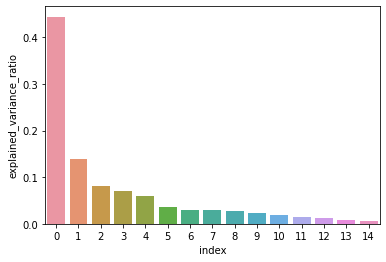

In [40]:
components = pd.DataFrame({'explained_variance_ratio': xgbreg_pca_mle.steps[2][1].explained_variance_ratio_})

sns.barplot(data=components.reset_index(), x='index', y='explained_variance_ratio')

In [41]:
for i in range(len(components)):
    print(f'Explained variance with {i} components: {round(components[:i].sum().values[0], 3)}')

Explained variance with 0 components: 0.0
Explained variance with 1 components: 0.444
Explained variance with 2 components: 0.584
Explained variance with 3 components: 0.665
Explained variance with 4 components: 0.736
Explained variance with 5 components: 0.795
Explained variance with 6 components: 0.831
Explained variance with 7 components: 0.862
Explained variance with 8 components: 0.891
Explained variance with 9 components: 0.917
Explained variance with 10 components: 0.94
Explained variance with 11 components: 0.96
Explained variance with 12 components: 0.975
Explained variance with 13 components: 0.987
Explained variance with 14 components: 0.994


Seguindo o PCA, para atingirmos 90% da variância explicada, precisamos utilizar ```9``` componentes.

## 2.6.2 PCA 9 componentes

In [42]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    df_train_raw, df_test_raw, target='selling_price', split_data=True
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'max_leaves': 0,
    'learning_rate': 0.05,
    
}

xgbreg_pca9 = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    PCA(n_components=9),
    XGBRegressor(n_jobs=-1, **params)
)

In [43]:
xgbreg_pca9.fit(x_train, y_train)

_preds = xgbreg_pca9.predict(x_test)
_ = calculate_scores('xgbreg_pca9', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910
xgbreg_basic,0.9755,972903.75,0.9755,71866.24,18.0886
xgbreg_manual_params,0.9741,1372574.50,0.9741,68383.20,16.6275
xgbreg_manual_params_larger,0.9732,1463839.75,0.9732,69554.37,16.7420
xgbreg_pca_mle,0.9653,1449168.88,0.9654,81329.06,19.8959


# 2.7 Keras DNN

## 2.7.1 Uns parametros jogados

In [44]:
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [45]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    train_set=df_train_raw, submission_set=df_test_raw, target='selling_price', split_data=True, test_size=0.15
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

keras_model = Sequential()
keras_model.add(Dense(128, kernel_initializer='normal', input_dim = x_train.shape[1], activation='relu'))

keras_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
keras_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
keras_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

keras_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

keras_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error', 'mean_absolute_error'])
keras_model.summary()

keras_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    keras_model
)

2022-04-25 11:50:24.569843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:50:24.574768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:50:24.575583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:50:24.576778: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2176      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 167,041
Trainable params: 167,041
Non-trainable params: 0
_________________________________________________________________


In [46]:
fit_params = {
    'sequential__epochs': 500,
    'sequential__batch_size': 32,
    'sequential__verbose': 0, 
    'sequential__callbacks': [TqdmCallback(verbose=1)]
}

keras_basic.fit(x_train, y_train, **fit_params)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-04-25 11:50:28.154789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5c0e517610>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5c0e517390>)])),
                ('robustscaler', RobustScaler()),
                ('sequential',
                 <keras.engine.sequential.Sequential object at 0x7f5c0e517750>)])

In [47]:
_preds = keras_basic.predict(x_test)
_ = calculate_scores('keras_basic', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910
xgbreg_basic,0.9755,972903.75,0.9755,71866.24,18.0886
xgbreg_manual_params,0.9741,1372574.50,0.9741,68383.20,16.6275
xgbreg_manual_params_larger,0.9732,1463839.75,0.9732,69554.37,16.7420
xgbreg_pca_mle,0.9653,1449168.88,0.9654,81329.06,19.8959


### 2.7.1.1 Submissão

In [48]:
keras_basic.fit(x_final, y_final, **fit_params)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5c0e517610>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5c0e517390>)])),
                ('robustscaler', RobustScaler()),
                ('sequential',
                 <keras.engine.sequential.Sequential object at 0x7f5c0e517750>)])

In [49]:
keras_basic.steps[-1][1].save('keras_basic.keras')

In [50]:
preds = keras_basic.predict(x_submission)
export_pred('keras_basic', x_submission, preds.flatten())

## 2.7.2 Números maiores

In [51]:
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [52]:
x_train, x_test, y_train, y_test, x_final, y_final, x_submission = preprocess(
    train_set=df_train_raw, submission_set=df_test_raw, target='selling_price', split_data=True, test_size=0.15
)

preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

keras_model = Sequential()
keras_model.add(Dense(256, kernel_initializer='normal', input_dim = x_train.shape[1], activation='relu'))

keras_model.add(Dense(1024, kernel_initializer='normal', activation='relu'))
keras_model.add(Dense(512, kernel_initializer='normal', activation='relu'))
keras_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

keras_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

keras_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error', 'mean_absolute_error'])
keras_model.summary()

keras_larger = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    keras_model
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               4352      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 923,905
Trainable params: 923,905
Non-trainable params: 0
_________________________________________________________________


In [53]:
fit_params = {
    'sequential__epochs': 1000,
    'sequential__batch_size': 32,
    'sequential__verbose': 0, 
    'sequential__callbacks': [TqdmCallback(verbose=1)],
    'sequential__use_multiprocessing': True,
    'sequential__workers': 4
}

keras_larger.fit(x_train, y_train, **fit_params)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cd67c7b50>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5baef77fd0>)])),
                ('robustscaler', RobustScaler()),
                ('sequential',
                 <keras.engine.sequential.Sequential object at 0x7f5c0ecf99d0>)])

In [54]:
_preds = keras_larger.predict(x_test)
_ = calculate_scores('keras_larger', y_test, _preds)

,r2_score,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
svr_basic,-0.0486,5549934.73,0.0002,376708.86,89.8819
linreg_basic,0.6689,3015136.06,0.6743,288823.33,90.0738
adareg_basic,0.8743,1500573.72,0.9178,229264.89,98.8738
adareg_manual_params,0.8099,1405349.34,0.9119,300827.21,125.2349
gbreg_basic,0.9008,1684436.14,0.9128,148156.05,39.9531
gbreg_manual_params,0.9709,1603500.95,0.9709,69887.61,16.7910
xgbreg_basic,0.9755,972903.75,0.9755,71866.24,18.0886
xgbreg_manual_params,0.9741,1372574.50,0.9741,68383.20,16.6275
xgbreg_manual_params_larger,0.9732,1463839.75,0.9732,69554.37,16.7420
xgbreg_pca_mle,0.9653,1449168.88,0.9654,81329.06,19.8959


### 2.7.2.1 Submissão

In [55]:
keras_larger.fit(x_final, y_final, **fit_params)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cd67c7b50>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5baef77fd0>)])),
                ('robustscaler', RobustScaler()),
                ('sequential',
                 <keras.engine.sequential.Sequential object at 0x7f5c0ecf99d0>)])

In [56]:
keras_larger.steps[-1][1].save('keras_larger.keras')

In [57]:
preds = keras_larger.predict(x_submission)
export_pred('keras_larger', x_submission, preds.flatten())